In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
sys.path.insert(0, '../')
from scipy import misc
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers.convolutional import Conv2D
from keras.layers import *
from keras import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,TensorBoard, Callback
import matplotlib.pyplot as plt
%matplotlib nbagg
from keras.utils import np_utils
from keras import backend as K
import cv2
from common import util
from sklearn.model_selection import train_test_split
import random
import glob
import tensorflow as tf
K.set_image_dim_ordering('th')

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/dlutils/plot_image_batch_w_labels.py:16: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
   

In [32]:
def hot_vectorize(x,value = 65287.0):
    zero_mask = x==value
    non_zero_mask = x!=value
    x[zero_mask] = 1
    x[non_zero_mask] = 0
    return x.astype(float)

def hot_vectorize1(x,value = 0):
    zero_mask = x==value
    non_zero_mask = x!=value
    x[zero_mask] = 1
    x[non_zero_mask] = 0
    return x.astype(float)

def stack_frames(frames,img_height,img_width,channels):
    stack  = np.zeros((1,img_height,img_width,channels))
    index = 0
    for i in frames:
        num_chan = 1 if len(np.shape(i)) ==2 else np.shape(i)[2]
        stack[0,:,:,index:index+num_chan] = np.reshape(i,(img_height,img_width,num_chan))
        index += num_chan
    return stack

def grab_frame(files,i,path,func=None):
    img = misc.imread(path+files[i])
    if func:
        return func(img)
    return img

def grab_frame1(path,func=None):
    img = misc.imread(path)
    if func:
        return func(img)
    return img

def normalize(x):
    return x.astype(float)/255.

def normalize_depth(x):
    return x.astype(float)/3000.

def convert_rgb_normal(img):
    return (img/255.*2)-1

def bounding_box(img,size = 100):
    h,w = np.shape(img)
    non_zeros = np.nonzero(img)
    x_min = np.min(non_zeros[0])
    x_max = np.max(non_zeros[0])
    y_min = np.min(non_zeros[1])
    y_max = np.max(non_zeros[1])
    out = (x_min,x_min+size,y_min,y_min+size) if size else (x_min,x_max,y_min,y_max)#minuce or plus coordinates
    if x_min< 0 or x_min+size > h or y_min<0 or y_min+size>w:
        return None
    return out

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


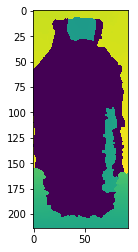

In [3]:
%matplotlib inline
plt.figure()
plt.imshow(misc.imread('/media/drc/DATA/wash_u/rgbd-dataset/water_bottle/water_bottle_6/water_bottle_6_1_20_depthcrop.png'))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


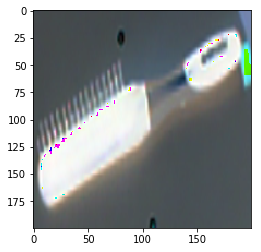

In [222]:
%matplotlib inline
next = gen.next()#seeing same crossboard lines
plt.imshow(np.swapaxes(np.swapaxes(next[0],axis1=1,axis2=3)[0,:,:,:],axis1=0,axis2=1))#youc an strech material properties augmentation works here

In [7]:
a = gen_samples1("/media/drc/DATA/wash_u/rgbd-dataset")#also try washu data set

In [8]:
gen = generate_data_custom_wash_u(a)



In [67]:
b = gen_samples("/media/drc/d92620ab-ae06-485e-8546-43a7a2d73059")#also try washu data set

In [80]:
gen = generate_data_custom_nyu(b,batch_size=2)

In [3]:
def gen_samples1(directory,shuffle = True):
    samples = []
    dirs = os.listdir(directory)
    for i in dirs:
        path = os.path.join(directory, i)+"/"
        for j in os.listdir(path):
            path1 = os.path.join(path, j)+"/"
            if os.access(path1, os.R_OK):
                rgb = sorted(glob.glob(path1+"*_crop*"))
                depth = sorted(glob.glob(path1+"*depth*"))
                samples.extend(zip(rgb,depth))
    if shuffle:
        random.shuffle(samples)
    return samples                

In [4]:
def gen_samples(directory,shuffle = True):
    samples = []
    dirs = os.listdir(directory)
    for i in dirs:
        path = os.path.join(directory, i)+"/"
        if os.access(path, os.R_OK):
            rgb = sorted(glob.glob(path+"r-*"))
            depth = sorted(glob.glob(path+"d-*"))
            samples.extend(zip(rgb,depth))
    if shuffle:
        random.shuffle(samples)
    return samples  

In [5]:
def generate_data_custom_wash_u(samples,batch_size=1):
    i = 0
    img_width =200
    img_height =200
    while True:
        stack1 = np.zeros((batch_size,3,img_height,img_width))
        stack2 = np.zeros((batch_size,1,img_height,img_width))
        j=0
        while j<batch_size:
            try:
                rgb = samples[i][0]
                depth = samples[i][1]
                rgb_img = misc.imresize(grab_frame1(rgb,normalize),(200,200))
                depth_img = misc.imresize(grab_frame1(depth,hot_vectorize),(200,200))
                stack1[j] = np.swapaxes(np.swapaxes(rgb_img,axis1=0,axis2=2),axis1 =2, axis2=1)
                stack2[j] = np.expand_dims(depth_img,axis=0)
                j+=1
                i= (i+1)%len(samples)
            except(IOError,TypeError,ValueError):
                i= (i+1)%len(samples)
                continue
        yield (np.asarray(stack1),np.asarray(stack2))

In [79]:
def generate_data_custom_nyu(samples,img_height=480,img_width=640,batch_size=4):
    i = 0
    while True:
        stack1 = np.zeros((batch_size,3,img_height,img_width))
        stack2 = np.zeros((batch_size,1,img_height,img_width))
        j=0
        while j<batch_size:
            try:
                rgb = samples[i][0]
                depth = samples[i][1]
                rgb_img = grab_frame1(rgb,normalize)
                depth_img = grab_frame1(depth,hot_vectorize)
                stack1[j] = np.swapaxes(np.swapaxes(rgb_img,axis1=0,axis2=2),axis1 =2, axis2=1)
                stack2[j] = np.expand_dims(depth_img,axis=0)
                j+=1
                i= (i+1)%len(samples)
            except(IOError,TypeError,ValueError):
                i= (i+1)%len(samples)
                continue
        yield (stack1,stack2)

In [7]:
def gen2(img_heigth=480,img_width=640,batch_size=4,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"
    depth_path = path+"depth/"

    rgb = np.sort(os.listdir(rgb_path))
    depth = np.sort(os.listdir(depth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            depth = np.sort(filter(lambda x: filter_files in x, depth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,3))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(rgb)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
          
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            stack = stack_frames([rgb_img],img_height,img_width,3)
            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [93]:
gen2 = gen2()

In [94]:
gen2.next()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


IOError: [Errno 21] Is a directory: '/media/drc/DATA/CNN/rgb/rgb'

In [13]:
def generate_data_custom3(depth_as_mask=True,img_height=480,img_width=640,batch_size=8,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"+"rgb/"
    depth_path = path+"depth/"+ "depth/"
    gtdepth_path = path+"gtdepth/" + "gtdepth/"
    normal_path = path+"normal/" + "normal/"

    rgb = np.sort(os.listdir(rgb_path))
    normal = np.sort(os.listdir(normal_path))
    depth = np.sort(os.listdir(depth_path))
    gtdepth = np.sort(os.listdir(gtdepth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            normal = np.sort(filter(lambda x: filter_files in x, normal))
            depth = np.sort(filter(lambda x: filter_files in x, depth))
            gtdepth = np.sort(filter(lambda x: filter_files in x, gtdepth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,7))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(depth)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
            normal_img = grab_frame(normal,i,normal_path,normalize)
            gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            gtdepth_img[gtdepth_img==0]=1.

            stack = stack_frames([gtdepth_img,normal_img,rgb_img],img_height,img_width,7)
            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [14]:
def generate_data_custom(depth_as_mask=True,img_height=480,img_width=640,batch_size=8,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"+"rgb/"
    depth_path = path+"depth/"+ "depth/"
    gtdepth_path = path+"gtdepth/" + "gtdepth/"
    normal_path = path+"normal/" + "normal/"

    rgb = np.sort(os.listdir(rgb_path))
    normal = np.sort(os.listdir(normal_path))
    depth = np.sort(os.listdir(depth_path))
    gtdepth = np.sort(os.listdir(gtdepth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            normal = np.sort(filter(lambda x: filter_files in x, normal))
            depth = np.sort(filter(lambda x: filter_files in x, depth))
            gtdepth = np.sort(filter(lambda x: filter_files in x, gtdepth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,4))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(depth)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
            normal_img = grab_frame(normal,i,normal_path,normalize)
            gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            a = bounding_box(gtdepth_img,img_height)
            while not a:
                i= (i+1)%len(depth)
                rgb_img = grab_frame(rgb,i,rgb_path,func)
                normal_img = grab_frame(normal,i,normal_path,normalize)
                gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
                depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
                a = bounding_box(gtdepth_img,img_height)

            x1,x2,y1,y2 = a
            depth_img = depth_img[x1:x2,y1:y2] 
            gtdepth_img = gtdepth_img[x1:x2,y1:y2]
            normal_img = normal_img[x1:x2,y1:y2]
            gtdepth_img[gtdepth_img==0]=1.

            stack = stack_frames([gtdepth_img,normal_img,rgb_img],img_height,img_width,4)
            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [8]:
gen  = generate_data_custom3(func=normalize)

NameError: name 'generate_data_custom3' is not defined

In [78]:
np.shape(now[1])

(614400,)

In [72]:
print np.reshape(now[1],(1,2,480,640))

[[[[1. 1. 0. ... 1. 1. 1.]
   [1. 0. 0. ... 1. 1. 1.]
   [0. 0. 0. ... 1. 1. 1.]
   ...
   [0. 0. 0. ... 1. 1. 1.]
   [0. 0. 0. ... 1. 1. 1.]
   [0. 0. 0. ... 1. 1. 1.]]

  [[0. 0. 1. ... 1. 1. 1.]
   [0. 0. 0. ... 1. 1. 1.]
   [0. 0. 0. ... 1. 1. 1.]
   ...
   [0. 0. 0. ... 1. 1. 1.]
   [0. 0. 0. ... 1. 1. 1.]
   [0. 0. 0. ... 1. 1. 1.]]]]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


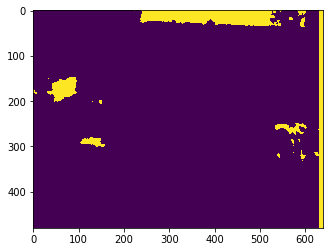

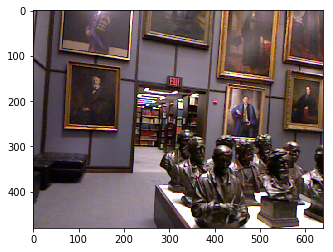

In [81]:
%matplotlib inline
h = 480
w = 640
now = gen.next()
zeros  = np.zeros((480,640,3))
zeros[:,:,0] = now[0][0,0,:,:]
zeros[:,:,1] = now[0][0,1,:,:]
zeros[:,:,2] = now[0][0,2,:,:]


plt.figure()
plt.imshow(np.reshape(now[1][1],(h,w)))
plt.figure()
plt.imshow(zeros)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


<IPython.core.display.Javascript object>


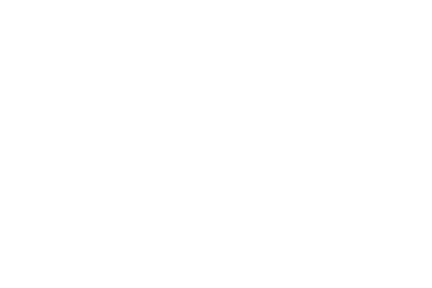

<IPython.core.display.Javascript object>


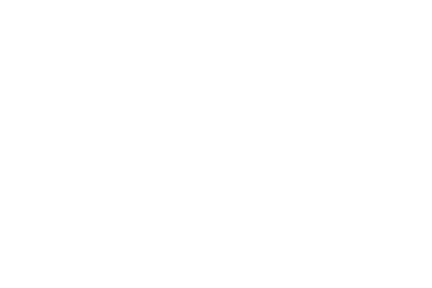

ValueError: cannot reshape array of size 1440 into shape (480,640)

<IPython.core.display.Javascript object>


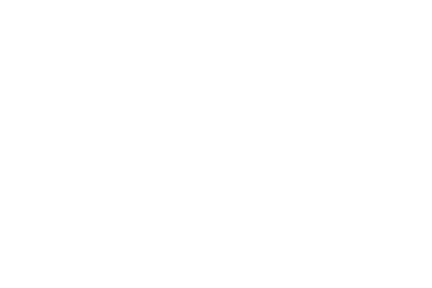

<IPython.core.display.Javascript object>


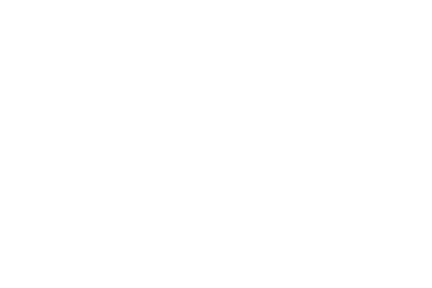

In [267]:
%matplotlib nbagg
now = gen.next()
plt.figure()
plt.imshow(np.reshape(now[1][0],(480,640)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,0],(480,640)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,1:4],(480,640,3)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,4:],(480,640,3)))

In [11]:
img_height = 480 #check with old params
img_width = 640
inputs = Input((3,img_height, img_width))

In [12]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np
from keras.layers import Conv2DTranspose

In [13]:
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

/usr/local/lib/python2.7/dist-packages/keras/applications/vgg16.py:188: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


In [218]:
b= my_model.layers[-1]

In [221]:
c = b.weights[0]

In [223]:
c.

<tf.Tensor 'conv2d_8/kernel/read:0' shape=(1, 1, 4, 1) dtype=float32>

In [217]:
for i in my_model.layers:
    print i

In [109]:
print model_vgg16_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 3, None, None)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, None, None)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, None, None)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, None, None)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, None, None)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, None, None)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, None, None)   0         
__________

In [94]:
input = Input(shape=(3,200,200),name = 'image_input')
new_model = VGG16(weights=None, input_shape=Input(shape=(3,200,200),name = 'image_input'), include_top=False)
for new_layer, layer in zip(new_model.layers[1:], model_vgg16_conv.layers[1:]):
    new_layer.set_weights(layer.get_weights())
new_model.summary()

TypeError: Using a `tf.Tensor` as a Python `bool` is not allowed. Use `if t is not None:` instead of `if t:` to test if a tensor is defined, and use TensorFlow ops such as tf.cond to execute subgraphs conditioned on the value of a tensor.

In [76]:
a= model_vgg16_conv.input


In [94]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np

#model = Model(inputs=model_vgg16_conv.input, outputs=model_vgg16_conv.get_layer('block3_pool').output) #also try adding layers to predefined model

model_vgg16_conv.input_layers
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format="channels_first")(model_vgg16_conv.get_layer('block2_pool').output)
conv10 = Conv2DTranspose(4, 3,strides=2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format="channels_first")(conv9)
conv11 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format="channels_first")(conv10)
conv12 = Conv2D(1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format="channels_first")(conv11)

#conv10 = Conv2DTranspose(4, 3, strides=4, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format="channels_first")(conv9)
#conv10 = Conv2DTranspose(4, 3, strides=4, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format="channels_first")(conv10)
#conv11 = Conv2DTranspose(1, 1, activation = 'sigmoid',data_format="channels_first")(conv10)

my_model = Model(input=model_vgg16_conv.input, output=conv12)

my_model.summary()
my_model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3, None, None)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, None, None)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, None, None)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, None, None)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, None, None)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, None, None)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, None, None)   0         
__________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [14]:
for i in range(8):
    model_vgg16_conv.layers.pop()
model_vgg16_conv.outputs = [model_vgg16_conv.layers[-1].output]
model_vgg16_conv.layers[-1].outbound_nodes = []
print model_vgg16_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, None, None)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, None, None)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, None, None)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, None, None)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, None, None)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, None, None)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, None, None)   0         
__________

In [95]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np

input = Input(shape=(3,480,640),name = 'image_input')

output_vgg16_conv = model_vgg16_conv(input)

conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(output_vgg16_conv)
conv10 = Conv2DTranspose(16, 3, strides=4, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2DTranspose(4, 3, strides=2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
conv11 = Conv2D(1, 1, activation = 'sigmoid')(conv10)
conv12 = Flatten()(conv11)

my_model = Model(input=input, output=conv11)

my_model.summary()categorical_accuracy
my_model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = weighted_pixelwise_crossentropy(class_weight), metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 3, 480, 640)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  1735488   
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 60, 80)        73760     
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 16, 240, 320)      4624      
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 4, 480, 640)       580       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 480, 640)       5         
Total params: 1,814,457
Trainable params: 1,814,457
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("im...)`


In [18]:
class Metrics(keras.callbacks.Callback):
    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0]))
        targ = self.validation_data[1]
        self.f1s=f1(targ, predict)
        return
metrics = Metrics()
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=[X_test,y_test], 
       verbose=1, callbacks=[metrics])

NameError: name 'keras' is not defined

In [83]:
class_weight = {0 : .85,
    1: .15}

In [94]:
def weighted_pixelwise_crossentropy(class_weights):
    
    def loss(y_true, y_pred):
        epsilon = tf.convert_to_tensor(.01, y_pred.dtype.base_dtype)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        return - tf.reduce_sum(tf.multiply(y_true * tf.log(y_pred), tf.convert_to_tensor(class_weights.values())))

    return loss

In [96]:
batch_size = 1
model_checkpoint = ModelCheckpoint('net_rgbnyu_vnet_batchsize4.hdf5', monitor='loss',verbose=1, save_best_only=True)
check2 = TensorBoard(log_dir='logs', histogram_freq=0, batch_size=8, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
print('Fitting model...')
my_model.fit_generator(gen, nb_epoch=10000,steps_per_epoch=100, verbose=1, shuffle=True,callbacks=[])

Fitting model...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=10000, callbacks=[])`
  """


Epoch 1/10000


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


InvalidArgumentError: Incompatible shapes: [2,1,480,640] vs. [2]
	 [[Node: loss_7/conv2d_16_loss/Mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](loss_7/conv2d_16_loss/mul, loss_7/conv2d_16_loss/Const_1)]]
	 [[Node: metrics_3/acc/Mean/_851 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1332_metrics_3/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op u'loss_7/conv2d_16_loss/Mul', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2828, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-95-b9a87e516da8>", line 21, in <module>
    my_model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = weighted_pixelwise_crossentropy(class_weight), metrics = ['accuracy'])
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/training.py", line 827, in compile
    sample_weight, mask)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/training.py", line 426, in weighted
    score_array = fn(y_true, y_pred)
  File "<ipython-input-94-752e97e677e1>", line 6, in loss
    return - tf.reduce_sum(tf.multiply(y_true * tf.log(y_pred), tf.convert_to_tensor(class_weights.values())))
  File "/home/drc/.local/lib/python2.7/site-packages/tensorflow/python/ops/math_ops.py", line 315, in multiply
    return gen_math_ops._mul(x, y, name)
  File "/home/drc/.local/lib/python2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2726, in _mul
    "Mul", x=x, y=y, name=name)
  File "/home/drc/.local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/drc/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/drc/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Incompatible shapes: [2,1,480,640] vs. [2]
	 [[Node: loss_7/conv2d_16_loss/Mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](loss_7/conv2d_16_loss/mul, loss_7/conv2d_16_loss/Const_1)]]
	 [[Node: metrics_3/acc/Mean/_851 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1332_metrics_3/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [137]:
#crop = Cropping2D(cropping=((0, 0), (0, 0)), data_format=None)
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(inputs)
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv1)

conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool1)
conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv2)

conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv3)


conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool3)
conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv5)
drop5 = Dropout(0.5)(conv5)

up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv5))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge7)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv7)

up8 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge8)
conv8 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv8)

up9 = Conv2D(4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge9)
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid',data_format='channels_last')(conv9)

model = Model(input = inputs, output = conv10)
print model.summary()
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 200, 200, 4)  0                                            
__________________________________________________________________________________________________
conv2d_210 (Conv2D)             (None, 200, 200, 4)  148         input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_211 (Conv2D)             (None, 200, 200, 4)  148         conv2d_210[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_50 (MaxPooling2D) (None, 100, 100, 4)  0           conv2d_211[0][0]                 
__________________________________________________________________________________________________
conv2d_212

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [13]:
#crop = Cropping2D(cropping=((0, 0), (0, 0)), data_format=None) #check with updated param in the middle weird???
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(inputs)
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv1)

conv2 = Conv2D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool1)
conv2 = Conv2D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv2)

conv3 = Conv2D(28, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool2)
conv3 = Conv2D(28, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv3)

conv4 = Conv2D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool3)
conv4 = Conv2D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(drop4)

conv5 = Conv2D(136, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool4)
conv5 = Conv2D(136, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(112, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(drop5))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = Conv2D(112, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge6)
conv6 = Conv2D(112, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv6)

up7 = Conv2D(56, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge7)
conv7 = Conv2D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv7)

up8 = Conv2D(28, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(28, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge8)
conv8 = Conv2D(28, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv8)

up9 = Conv2D(14, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge9)
conv9 = Conv2D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid',data_format='channels_last')(conv9)

model = Model(input = inputs, output = conv10)
print model.summary()
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:34: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: UserWarning: The `m

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 640, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 480, 640, 4)  112         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 480, 640, 4)  148         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 240, 320, 4)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [14]:
model.load_weights('RGBDCNN/net_rgbnyu_batchsize8_3000epoch.hdf5')

In [16]:
from keras import backend as K


In [63]:
class Image_Saver(Callback):
    def on_train_begin(self,logs={}):
        self.var_y_pred = tf.placeholder(tf.float32, [FLAGS.batch_size, 480,640,1])
        #self.var_y_pred = tf.Variable(0., validate_shape=False)

    def on_batch_end(self, batch, logs={}):
            #callback = TensorBoard(log_path)
            #callback.set_model(model)
            
            print type(K.eval(self.model.outputs[0]))
            x=self.model.predict_on_batch(batch)
            writer = tf.summary.FileWriter('./logs')
            writer.add_summary(tf.summary.image('input', x[0]))
save = Image_Saver()

In [82]:
model_checkpoint = ModelCheckpoint('net_rgbnyu_batchsize8.hdf5', monitor='loss',verbose=1, save_best_only=True)
check2 = TensorBoard(log_dir='logs', histogram_freq=0, batch_size=8, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
print('Fitting model...')
model.fit_generator(gen, nb_epoch=1000,steps_per_epoch=100, verbose=1, shuffle=True, callbacks=[model_checkpoint,check2])

Fitting model...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=1000, callbacks=[<keras.ca...)`
  after removing the cwd from sys.path.


Epoch 1/1000


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


 99/100 [============================>.] - ETA: 0s - loss: 0.2241 - acc: 0.9119
Epoch 00001: loss improved from inf to 0.22400, saving model to net_rgbnyu_batchsize8.hdf5
100/100 [==============================] - 84s 838ms/step - loss: 0.2240 - acc: 0.9119
Epoch 2/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2237 - acc: 0.9117
Epoch 00002: loss improved from 0.22400 to 0.22376, saving model to net_rgbnyu_batchsize8.hdf5
100/100 [==============================] - 83s 834ms/step - loss: 0.2238 - acc: 0.9117
Epoch 3/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2293 - acc: 0.9098
Epoch 00003: loss did not improve
100/100 [==============================] - 84s 836ms/step - loss: 0.2297 - acc: 0.9096
Epoch 4/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2330 - acc: 0.9075
Epoch 00004: loss did not improve
100/100 [==============================] - 85s 854ms/step - loss: 0.2326 - acc: 0.9077
Epoch 5/1000
 99/100 [=================

Epoch 38/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2224 - acc: 0.9132
Epoch 00038: loss did not improve
100/100 [==============================] - 83s 833ms/step - loss: 0.2220 - acc: 0.9134
Epoch 39/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2330 - acc: 0.9092
Epoch 00039: loss did not improve
100/100 [==============================] - 85s 849ms/step - loss: 0.2328 - acc: 0.9092
Epoch 40/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2328 - acc: 0.9087
Epoch 00040: loss did not improve
100/100 [==============================] - 83s 835ms/step - loss: 0.2329 - acc: 0.9087
Epoch 41/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2207 - acc: 0.9132
Epoch 00041: loss did not improve
100/100 [==============================] - 83s 834ms/step - loss: 0.2213 - acc: 0.9129
Epoch 42/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2291 - acc: 0.9099
Epoch 00042: loss did not improve
100/100 [===

KeyboardInterrupt: 

In [ ]:
X_Test1 = np.copy(X_Test)
X_Test1[:,:,:,0]=0
X_Test1[:,:,:,1:4]=0
#X_Test1[:,:,:,4:]=0
imgs_mask_test = model.predict_on_batch(X_Test1)

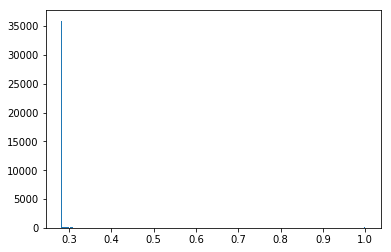

In [162]:
plt.figure()
plt.hist(img.ravel(), bins=256)
plt.show()

In [113]:
path = "/media/drc/DATA/Redwood/trash_can/"
path = "/media/drc/DATA/chris_labelfusion/CORL2017/object_database/"
i = np.random.randint(len(os.listdir(path+"/depth")))
d =  misc.imread(path+"/depth/"+os.listdir(path+"/depth")[i])
rgb = misc.imread(path+"/rgb/"+os.listdir(path+"/rgb")[i])
imgs_mask_test = model.predict_on_batch(np.reshape(rgb,(1,480,640,3)))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


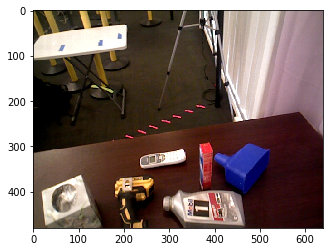

In [114]:
%matplotlib inline
plt.figure()
plt.imshow(rgb)

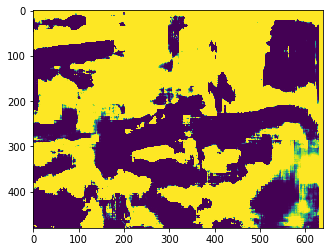

In [115]:
%matplotlib inline
img = np.reshape(imgs_mask_test[0],(img_height,img_width))
plt.imshow(img)

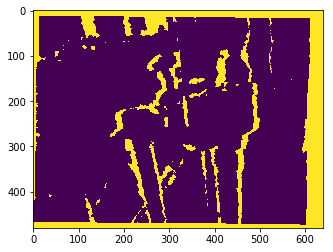

In [111]:
%matplotlib inline
plt.figure()
m1 = d==0
m2 = d!=0
d[m1] =1
d[m2] = 0
plt.imshow(d)

In [24]:
test = gen.next()
X_Test = test[0][0:1]

Y_Test = test[1][0:1]
imgs_mask_test = my_model.predict_on_batch(X_Test)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [28]:
np.shape(X_Test[0])

(3, 480, 640)

In [39]:
np.shape(m)

(2, 1, 480, 640)

In [55]:
np.shape(m)

(2, 1, 480, 640)

In [70]:
np.shape(now[1])

(2, 1, 480, 640)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


0.017141927083333335 0.9828580729166667


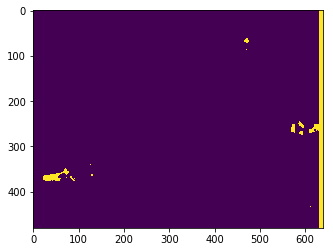

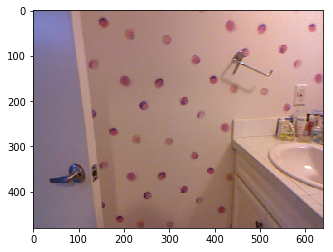

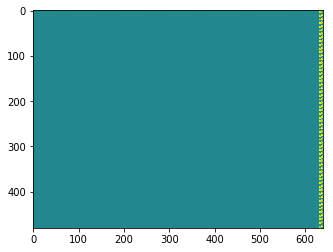

In [20]:
%matplotlib inline
h = 480
w = 640
now = gen.next()
zeros  = np.zeros((480,640,3))
zeros[:,:,0] = now[0][0][0]
zeros[:,:,1] = now[0][0][1]
zeros[:,:,2] = now[0][0][2]

plt.figure()
plt.imshow(np.reshape(now[1][0],(h,w)))
plt.figure()
plt.imshow(zeros)
plt.figure()
m = my_model.predict_on_batch(now[0])

plt.imshow(m[0,0,:,:])
c = np.reshape(now[1][0],(h,w)).flatten()
print np.sum(c)/float(len(c)),1-(np.sum(c)/float(len(c)))

In [38]:
np.shape(np.expand_dims(np.rollaxis(img,2,0),0))

NameError: name 'img' is not defined

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


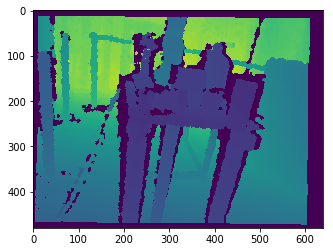

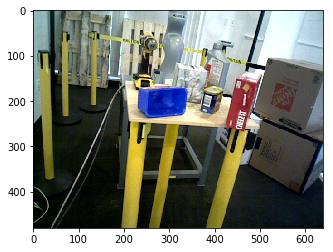

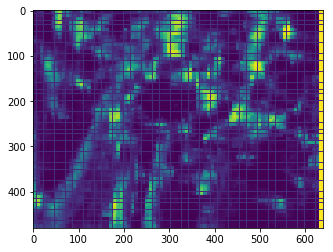

In [166]:
rgb = np.sort(os.listdir("/media/drc/DATA/CNN/rgb/rgb"))
depth = np.sort(os.listdir("/media/drc/DATA/CNN/depth/depth"))
ran = np.random.randint(len(depth))
imd = misc.imread("/media/drc/DATA/CNN/depth/depth/"+depth[ran])
img = misc.imread("/media/drc/DATA/CNN/rgb/rgb/"+rgb[ran])
plt.figure()
plt.imshow(imd)
plt.figure()
plt.imshow(img)
plt.figure()
l = np.expand_dims(np.rollaxis(img,2,0),0)/255.
m = my_model.predict_on_batch(l)
plt.imshow(m[0,0,:,:])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


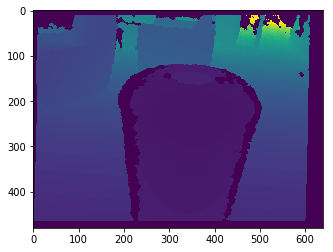

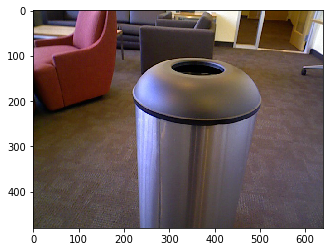

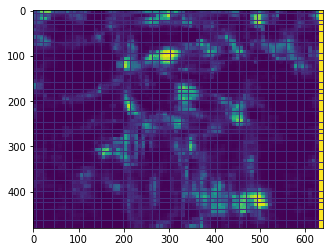

In [165]:
rgb = np.sort(os.listdir("/media/drc/DATA/Redwood/trash_can/rgb"))
depth = np.sort(os.listdir("/media/drc/DATA/Redwood/trash_can/depth"))
ran = np.random.randint(len(depth))
imd = misc.imread("/media/drc/DATA/Redwood/trash_can/depth/"+depth[ran])
img = misc.imread("/media/drc/DATA/Redwood/trash_can/rgb/"+rgb[ran])
plt.figure()
plt.imshow(imd)
plt.figure()
plt.imshow(img)
plt.figure()
l = np.expand_dims(np.rollaxis(img,2,0),0)/255.
m = my_model.predict_on_batch(l)
plt.imshow(m[0,0,:,:])

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [40]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

In [190]:
list(np.round([.5,.1]).astype(int))

[0, 0]

In [63]:
def test_on_set(rgb_dir,depth_dir,model,size):
    rgb = np.sort(os.listdir(rgb_dir))[:size]
    depth = np.sort(os.listdir(depth_dir))[:size]
    data = np.zeros((1,3,480,640))
    pred = []
    targ = []
    prob = []
    for i,j,l in zip(rgb,depth,range(size)):
        r = normalize(misc.imread(rgb_dir+i))
        r = np.expand_dims(np.rollaxis(r,2,0),0)
        data[0] = r
        d = hot_vectorize1(misc.imread(depth_dir+j))
        p = model.predict_on_batch(data).flatten()
        prob.extend(p)
        pred.extend(list((np.round(p).astype(int))))
        targ.extend(list(d.flatten().astype(int)))
    roc = roc_curve(targ,prob)
    plt.figure()
    plt.plot(roc[0],roc[1])
    return (f1_score(targ,pred),roc)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':


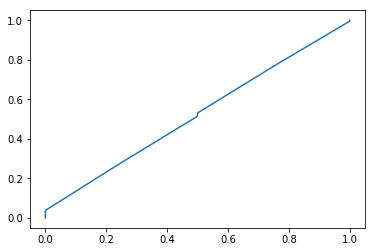

In [64]:
b= test_on_set("/media/drc/DATA/CNN/rgb/rgb/","/media/drc/DATA/CNN/depth/depth/",my_model,10)

In [57]:
np.shape(b[2])

(3, 679)

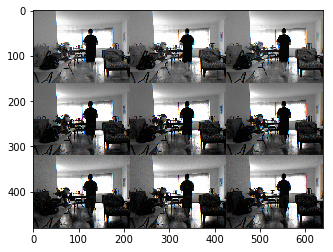

In [193]:
%matplotlib inline
img = np.reshape(X_Test[0][:,:,:],(img_height,img_width,3))
plt.imshow(img)

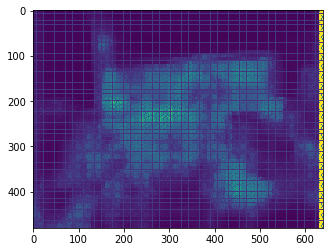

In [26]:
%matplotlib inline
img = np.reshape(imgs_mask_test[0],(img_height,img_width))
plt.imshow(img)

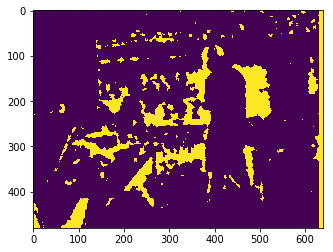

In [53]:
%matplotlib inline
img1 = np.reshape(Y_Test[0],(img_height,img_width))
plt.imshow(img1)

In [ ]:
img1 = np.copy(img)
img1[img1>.3] =1
plt.imshow(img1)

In [169]:
train = train_generator.next()
X = train[0]
Y = train[1]
inputs = Input((1,img_height, img_width))

In [171]:
conv1 = Conv2D(32, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(inputs)

conv2 = Conv2D(64, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv1)

conv3 = Conv2D(32, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv2)

conv4 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv3)
#drop4 = Dropout(0.5)(conv4)

conv5 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv4)

conv6 = Conv2D(1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv5)
#drop5 = Dropout(0.5)(conv5)


model1 = Model(input = inputs, output = conv6)
print model1.summary()
model1.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 480, 640)       0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 32, 480, 640)      832       
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 64, 480, 640)      51264     
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 32, 480, 640)      51232     
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 16, 480, 640)      4624      
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 4, 480, 640)       580       
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 1, 480, 640)       37        
Total para

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
  from ipykernel import kernelapp as app


In [217]:
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
print('Fitting model...')
model1.fit_generator(train_generator, steps_per_epoch=100,nb_epoch=10, verbose=1, shuffle=True, callbacks=[model_checkpoint])

Fitting model...
Epoch 1/10
  1/100 [..............................] - ETA: 13s - loss: 0.3969 - acc: 0.8304

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<itertools..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=10, callbacks=[<keras.ca...)`
  This is separate from the ipykernel package so we can avoid doing imports until


 99/100 [============================>.] - ETA: 0s - loss: 0.3890 - acc: 0.8321
Epoch 00001: loss improved from inf to 0.38894, saving model to unet.hdf5
100/100 [==============================] - 10s 100ms/step - loss: 0.3889 - acc: 0.8322
Epoch 2/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3845 - acc: 0.8345
Epoch 00002: loss improved from 0.38894 to 0.38439, saving model to unet.hdf5
100/100 [==============================] - 10s 97ms/step - loss: 0.3844 - acc: 0.8345
Epoch 3/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3850 - acc: 0.8282
Epoch 00003: loss did not improve
100/100 [==============================] - 10s 97ms/step - loss: 0.3851 - acc: 0.8281
Epoch 4/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3777 - acc: 0.8301
Epoch 00004: loss improved from 0.38439 to 0.37768, saving model to unet.hdf5
100/100 [==============================] - 10s 98ms/step - loss: 0.3777 - acc: 0.8301
Epoch 5/10
 99/100 [==================

In [229]:
test = train_generator.next()
X_Test = test[0][0:50]
Y_Test = test[1][0:50]

In [232]:
np.shape(X_Test),np.shape(imgs_mask_test)

((1, 1, 480, 640), (1, 1, 480, 640))

In [236]:
imgs_mask_test = model1.predict_on_batch(X_Test)

In [284]:
%matplotlib inline

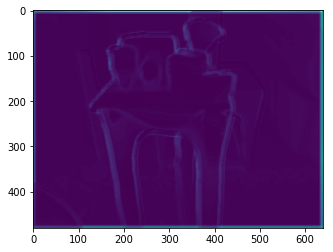

In [242]:
index = np.random.randint(10)
img = np.reshape(imgs_mask_test,(img_height,img_width))
plt.imshow(img)

In [34]:
count = 0

In [177]:
from PIL import Image
im = Image.open(img)
plt.imshow(im)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


<IPython.core.display.Javascript object>


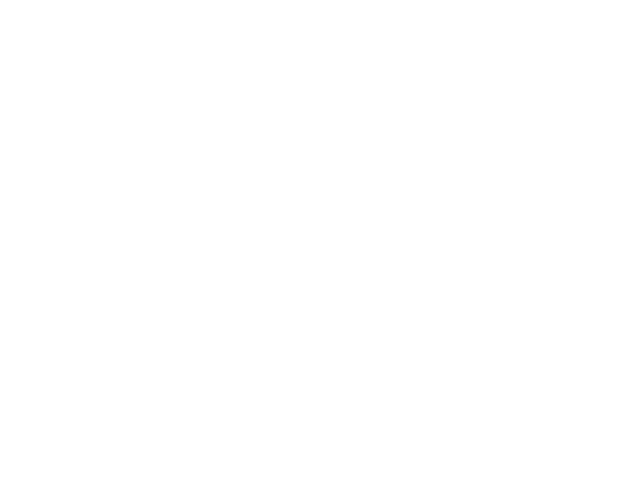

In [187]:
%matplotlib nbagg
path = "/media/drc/DATA/CNN/gtdepth/gtdepth/0000000007_2017-05-25-19_depth_ground_truth.png"
#path = "/media/drc/DATA/CNN/gtdepth/gtdepth/"
#img = path+ os.listdir(path)[count]
test =  misc.imresize(misc.imread(path),(480,640))
plt.imshow(test)
count+=1

In [282]:
%%timeit
perlin(x,y,seed=2)

100 loops, best of 3: 4.57 ms per loop


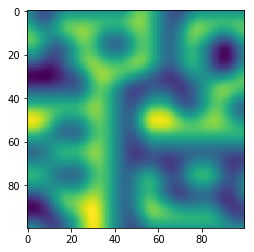

In [269]:
def perlin(x,y,seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u) # FIX1: I was using n10 instead of n01
    return lerp(x1,x2,v) # FIX2: I also had to reverse x1 and x2 here

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y

lin = np.linspace(0,5,100,endpoint=False)
x,y = np.meshgrid(lin,lin) # FIX3: I thought I had to invert x and y here but it was a mistake
plt.figure()
plt.imshow(perlin(x,y,seed=2),origin='upper')

In [270]:
img

array([[0.7112028, 0.7112028, 0.7112028, ..., 0.7112028, 0.7112028,
        0.7112028],
       [0.7112028, 0.7112028, 0.7112028, ..., 0.7112028, 0.7112028,
        0.7112028],
       [0.7112028, 0.7112028, 0.7112028, ..., 0.7112028, 0.7112028,
        0.7112028],
       ...,
       [0.7112028, 0.7112028, 0.7112028, ..., 0.7112028, 0.7112028,
        0.7112028],
       [0.7112028, 0.7112028, 0.7112028, ..., 0.7112028, 0.7112028,
        0.7112028],
       [0.7112028, 0.7112028, 0.7112028, ..., 0.7112028, 0.7112028,
        0.7112028]], dtype=float32)

In [281]:
%%timeit
edges1 = filter.canny(rg)

10 loops, best of 3: 79.8 ms per loop


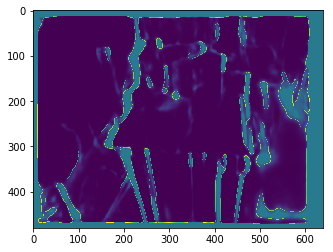

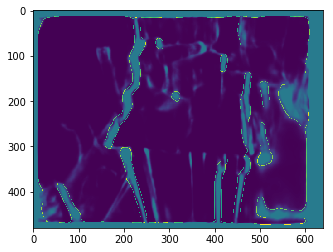

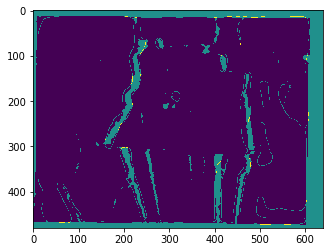

In [279]:
from scipy import ndimage as ndi
from skimage import filter
from skimage import color
from skimage import io
rg = ndi.gaussian_filter(img,4)
edges1 = filter.canny(rg)
edges2 = filter.canny(rg,sigma =6)
plt.figure()
plt.imshow(edges1+img)
plt.figure()
plt.imshow(edges2+img)
plt.figure()
plt.imshow(edges2+img1)

In [293]:
from scipy.ndimage import (gaussian_filter,
                           generate_binary_structure, binary_erosion, label)

In [294]:
%%timeit
gaussian_filter(img, 1, mode='constant')

100 loops, best of 3: 4.56 ms per loop


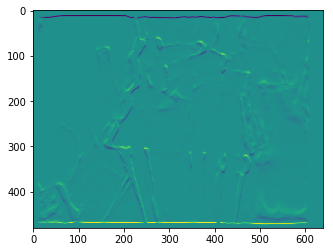

In [299]:
img_smooth = gaussian_filter(img, .5, mode='constant')
plt.imshow(np.gradient(img_smooth)[0])

In [ ]:
"""
canny.py - Canny Edge detector

Reference: Canny, J., A Computational Approach To Edge Detection, IEEE Trans.
    Pattern Analysis and Machine Intelligence, 8:679-714, 1986

Originally part of CellProfiler, code licensed under both GPL and BSD licenses.
Website: http://www.cellprofiler.org
Copyright (c) 2003-2009 Massachusetts Institute of Technology
Copyright (c) 2009-2011 Broad Institute
All rights reserved.
Original author: Lee Kamentsky
"""

import numpy as np
import scipy.ndimage as ndi
from scipy.ndimage import (gaussian_filter,
                           generate_binary_structure, binary_erosion, label)
from .. import dtype_limits
from .._shared.utils import assert_nD


def smooth_with_function_and_mask(image, function, mask):
    """Smooth an image with a linear function, ignoring masked pixels

    Parameters
    ----------
    image : array
        Image you want to smooth.
    function : callable
        A function that does image smoothing.
    mask : array
        Mask with 1's for significant pixels, 0's for masked pixels.

    Notes
    ------
    This function calculates the fractional contribution of masked pixels
    by applying the function to the mask (which gets you the fraction of
    the pixel data that's due to significant points). We then mask the image
    and apply the function. The resulting values will be lower by the
    bleed-over fraction, so you can recalibrate by dividing by the function
    on the mask to recover the effect of smoothing from just the significant
    pixels.
    """
    bleed_over = function(mask.astype(float))
    masked_image = np.zeros(image.shape, image.dtype)
    masked_image[mask] = image[mask]
    smoothed_image = function(masked_image)
    output_image = smoothed_image / (bleed_over + np.finfo(float).eps)
    return output_image


def canny(image, sigma=1., low_threshold=None, high_threshold=None, mask=None,
          use_quantiles=False):
    """Edge filter an image using the Canny algorithm.

    Parameters
    -----------
    image : 2D array
        Greyscale input image to detect edges on; can be of any dtype.
    sigma : float
        Standard deviation of the Gaussian filter.
    low_threshold : float
        Lower bound for hysteresis thresholding (linking edges).
        If None, low_threshold is set to 10% of dtype's max.
    high_threshold : float
        Upper bound for hysteresis thresholding (linking edges).
        If None, high_threshold is set to 20% of dtype's max.
    mask : array, dtype=bool, optional
        Mask to limit the application of Canny to a certain area.
    use_quantiles : bool, optional
        If True then treat low_threshold and high_threshold as quantiles of the
        edge magnitude image, rather than absolute edge magnitude values. If True
        then the thresholds must be in the range [0, 1].

    Returns
    -------
    output : 2D array (image)
        The binary edge map.

    See also
    --------
    skimage.sobel

    Notes
    -----
    The steps of the algorithm are as follows:

    * Smooth the image using a Gaussian with ``sigma`` width.

    * Apply the horizontal and vertical Sobel operators to get the gradients
      within the image. The edge strength is the norm of the gradient.

    * Thin potential edges to 1-pixel wide curves. First, find the normal
      to the edge at each point. This is done by looking at the
      signs and the relative magnitude of the X-Sobel and Y-Sobel
      to sort the points into 4 categories: horizontal, vertical,
      diagonal and antidiagonal. Then look in the normal and reverse
      directions to see if the values in either of those directions are
      greater than the point in question. Use interpolation to get a mix of
      points instead of picking the one that's the closest to the normal.

    * Perform a hysteresis thresholding: first label all points above the
      high threshold as edges. Then recursively label any point above the
      low threshold that is 8-connected to a labeled point as an edge.

    References
    -----------
    .. [1] Canny, J., A Computational Approach To Edge Detection, IEEE Trans.
           Pattern Analysis and Machine Intelligence, 8:679-714, 1986
    .. [2] William Green's Canny tutorial
           http://dasl.mem.drexel.edu/alumni/bGreen/www.pages.drexel.edu/_weg22/can_tut.html

    Examples
    --------
    >>> from skimage import feature
    >>> # Generate noisy image of a square
    >>> im = np.zeros((256, 256))
    >>> im[64:-64, 64:-64] = 1
    >>> im += 0.2 * np.random.rand(*im.shape)
    >>> # First trial with the Canny filter, with the default smoothing
    >>> edges1 = feature.canny(im)
    >>> # Increase the smoothing for better results
    >>> edges2 = feature.canny(im, sigma=3)
    """

    #
    # The steps involved:
    #
    # * Smooth using the Gaussian with sigma above.
    #
    # * Apply the horizontal and vertical Sobel operators to get the gradients
    #   within the image. The edge strength is the sum of the magnitudes
    #   of the gradients in each direction.
    #
    # * Find the normal to the edge at each point using the arctangent of the
    #   ratio of the Y sobel over the X sobel - pragmatically, we can
    #   look at the signs of X and Y and the relative magnitude of X vs Y
    #   to sort the points into 4 categories: horizontal, vertical,
    #   diagonal and antidiagonal.
    #
    # * Look in the normal and reverse directions to see if the values
    #   in either of those directions are greater than the point in question.
    #   Use interpolation to get a mix of points instead of picking the one
    #   that's the closest to the normal.
    #
    # * Label all points above the high threshold as edges.
    # * Recursively label any point above the low threshold that is 8-connected
    #   to a labeled point as an edge.
    #
    # Regarding masks, any point touching a masked point will have a gradient
    # that is "infected" by the masked point, so it's enough to erode the
    # mask by one and then mask the output. We also mask out the border points
    # because who knows what lies beyond the edge of the image?
    #
    assert_nD(image, 2)

    if low_threshold is None:
        low_threshold = 0.1 * dtype_limits(image, clip_negative=False)[1]

    if high_threshold is None:
        high_threshold = 0.2 * dtype_limits(image, clip_negative=False)[1]

    if mask is None:
        mask = np.ones(image.shape, dtype=bool)

    def fsmooth(x):
        return gaussian_filter(x, sigma, mode='constant')

    smoothed = smooth_with_function_and_mask(image, fsmooth, mask)
    jsobel = ndi.sobel(smoothed, axis=1)
    isobel = ndi.sobel(smoothed, axis=0)
    abs_isobel = np.abs(isobel)
    abs_jsobel = np.abs(jsobel)
    magnitude = np.hypot(isobel, jsobel)

    #
    # Make the eroded mask. Setting the border value to zero will wipe
    # out the image edges for us.
    #
    s = generate_binary_structure(2, 2)
    eroded_mask = binary_erosion(mask, s, border_value=0)
    eroded_mask = eroded_mask & (magnitude > 0)
    #
    #--------- Find local maxima --------------
    #
    # Assign each point to have a normal of 0-45 degrees, 45-90 degrees,
    # 90-135 degrees and 135-180 degrees.
    #
    local_maxima = np.zeros(image.shape, bool)
    #----- 0 to 45 degrees ------
    pts_plus = (isobel >= 0) & (jsobel >= 0) & (abs_isobel >= abs_jsobel)
    pts_minus = (isobel <= 0) & (jsobel <= 0) & (abs_isobel >= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    # Get the magnitudes shifted left to make a matrix of the points to the
    # right of pts. Similarly, shift left and down to get the points to the
    # top right of pts.
    c1 = magnitude[1:, :][pts[:-1, :]]
    c2 = magnitude[1:, 1:][pts[:-1, :-1]]
    m = magnitude[pts]
    w = abs_jsobel[pts] / abs_isobel[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[:-1, :][pts[1:, :]]
    c2 = magnitude[:-1, :-1][pts[1:, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus
    #----- 45 to 90 degrees ------
    # Mix diagonal and vertical
    #
    pts_plus = (isobel >= 0) & (jsobel >= 0) & (abs_isobel <= abs_jsobel)
    pts_minus = (isobel <= 0) & (jsobel <= 0) & (abs_isobel <= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1 = magnitude[:, 1:][pts[:, :-1]]
    c2 = magnitude[1:, 1:][pts[:-1, :-1]]
    m = magnitude[pts]
    w = abs_isobel[pts] / abs_jsobel[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[:, :-1][pts[:, 1:]]
    c2 = magnitude[:-1, :-1][pts[1:, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus
    #----- 90 to 135 degrees ------
    # Mix anti-diagonal and vertical
    #
    pts_plus = (isobel <= 0) & (jsobel >= 0) & (abs_isobel <= abs_jsobel)
    pts_minus = (isobel >= 0) & (jsobel <= 0) & (abs_isobel <= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1a = magnitude[:, 1:][pts[:, :-1]]
    c2a = magnitude[:-1, 1:][pts[1:, :-1]]
    m = magnitude[pts]
    w = abs_isobel[pts] / abs_jsobel[pts]
    c_plus = c2a * w + c1a * (1.0 - w) <= m
    c1 = magnitude[:, :-1][pts[:, 1:]]
    c2 = magnitude[1:, :-1][pts[:-1, 1:]]
    c_minus = c2 * w + c1 * (1.0 - w) <= m
    local_maxima[pts] = c_plus & c_minus
    #----- 135 to 180 degrees ------
    # Mix anti-diagonal and anti-horizontal
    #
    pts_plus = (isobel <= 0) & (jsobel >= 0) & (abs_isobel >= abs_jsobel)
    pts_minus = (isobel >= 0) & (jsobel <= 0) & (abs_isobel >= abs_jsobel)
    pts = pts_plus | pts_minus
    pts = eroded_mask & pts
    c1 = magnitude[:-1, :][pts[1:, :]]
    c2 = magnitude[:-1, 1:][pts[1:, :-1]]
    m = magnitude[pts]
    w = abs_jsobel[pts] / abs_isobel[pts]
    c_plus = c2 * w + c1 * (1 - w) <= m
    c1 = magnitude[1:, :][pts[:-1, :]]
    c2 = magnitude[1:, :-1][pts[:-1, 1:]]
    c_minus = c2 * w + c1 * (1 - w) <= m
    local_maxima[pts] = c_plus & c_minus

    #
    #---- If use_quantiles is set then calculate the thresholds to use
    #
    if use_quantiles:
        if high_threshold > 1.0 or low_threshold > 1.0:
            raise ValueError("Quantile thresholds must not be > 1.0")
        if high_threshold < 0.0 or low_threshold < 0.0:
            raise ValueError("Quantile thresholds must not be < 0.0")

        high_threshold = np.percentile(magnitude, 100.0 * high_threshold)
        low_threshold = np.percentile(magnitude, 100.0 * low_threshold)

    #
    #---- Create two masks at the two thresholds.
    #
    high_mask = local_maxima & (magnitude >= high_threshold)
    low_mask = local_maxima & (magnitude >= low_threshold)
    #
    # Segment the low-mask, then only keep low-segments that have
    # some high_mask component in them
    #
    strel = np.ones((3, 3), bool)
    labels, count = label(low_mask, strel)
    if count == 0:
        return low_mask

    sums = (np.array(ndi.sum(high_mask, labels,
                             np.arange(count, dtype=np.int32) + 1),
                     copy=False, ndmin=1))
    good_label = np.zeros((count + 1,), bool)
    good_label[1:] = sums > 0
    output_mask = good_label[labels]
    return output_mask